<a href="https://colab.research.google.com/github/OWLYone/ITGRA2022_AIREPOS/blob/main/(r)SSD_Email_cat_1_full_MS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt_text](https://cdn-images-1.medium.com/max/1600/0*a6XSwHsfvz_oWSSJ.jpg)

![alt_text](https://www.capgemini.com/pl-pl/wp-content/themes/capgemini-2018/assets/images/logo.svg)
# rSSD - Text Categorizer - ML Logic Prep
Marek A. Sowa v1

#Dependencies

In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
#!pip install urllib
from urllib.request import urlretrieve
from scipy import stats

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models

print("You have TensorFlow version", tf.__version__)
#Dependencies for GCP GCS
from google.colab import auth
#auth.authenticate_user()


You have TensorFlow version 1.12.0


In [ ]:
#Visuals
import seaborn as sns

#Get Data

In [ ]:
#Get data from onlie blob storage (Azure)
data_link = "https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv"
data_filename = "data.csv"

In [ ]:
def download_file(file_url, folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    if not os.path.exists(file_path):
        print('Downloading file from ' + file_url + '...')
        urlretrieve(file_url, file_path)
        print('Done downloading file: '+file_path)
    else:
        print('File: ' + file_path + ' already exists.')
        
def download_dataset():
    print('Downloading tickets dataset...')
    folder_path = os.path.join(
        os.path.dirname(
            os.path.abspath(__file__)
        ),
        'datasets'
    )
    
    download_file(url, folder_path, file_name)

In [ ]:
download_file(data_link, "", data_filename)
data = pd.read_csv(data_filename)

File: data.csv already exists.


In [ ]:
data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [ ]:
data.columns

Index(['title', 'body', 'ticket_type', 'category', 'sub_category1',
       'sub_category2', 'business_service', 'urgency', 'impact'],
      dtype='object')

In [ ]:
#Get Shape
data.shape

(48549, 9)

#Visual data verification

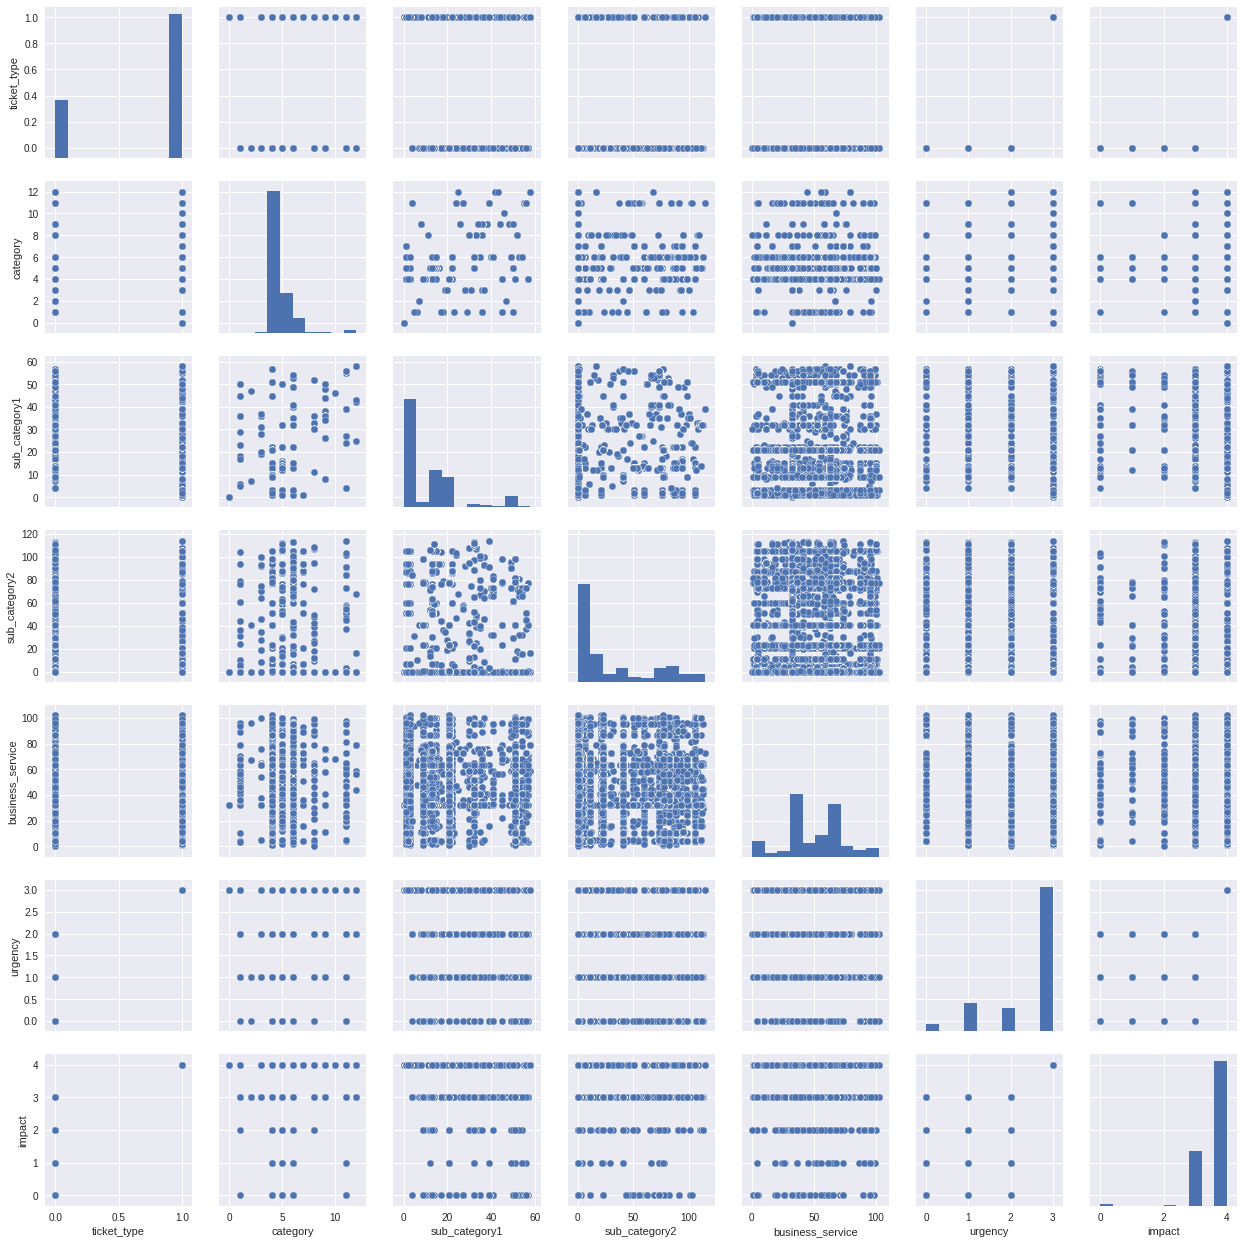

In [ ]:
sns.set(color_codes=True)
sns.pairplot(data)

##Data deep dive

In [ ]:
data['category'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

#Data preparation

In [ ]:
pre_na = data.shape
print(pre_na)
#(48549, 9)

(48549, 9)


In [ ]:
#Discover NANs
len(data) - data.count()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data = data[data.category != 1]
data = data[data.category != 12]
data = data[data.category != 2]
data = data[data.category != 10]

In [ ]:
post_na = data.shape
print("PRE: "+str(pre_na))
print("POST: "+str(post_na))

PRE: (48549, 9)
POST: (47717, 9)


In [ ]:
train_size = int(len(data) * .70)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 33401
Test size: 14316


In [ ]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [ ]:
#Since its tuple, split per column
train_cat, test_cat = train_test_split(data['category'], train_size)
train_text, test_text = train_test_split(data['body'], train_size)

#Tokenize

In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [ ]:
tokenize.fit_on_texts(train_text)
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

#Encode

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

##One Hot Encoding

In [ ]:
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Shape Inspection

In [ ]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (33401, 1000)
x_test shape: (14316, 1000)
y_train shape: (33401, 9)
y_test shape: (14316, 9)


#Model Training (KERAS)

In [ ]:
batch_size = 128
epochs = 100
drop_ratio = 0.2

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 26720 samples, validate on 6681 samples
Epoch 1/100
26720/26720 [==============================] - 4s 135us/step - loss: 0.6104 - acc: 0.8172 - val_loss: 0.6062 - val_acc: 0.8195
Epoch 2/100
26720/26720 [==============================] - 1s 52us/step - loss: 0.3988 - acc: 0.8653 - val_loss: 0.5886 - val_acc: 0.8192
Epoch 3/100
26720/26720 [==============================] - 1s 53us/step - loss: 0.3447 - acc: 0.8806 - val_loss: 0.6272 - val_acc: 0.8150
Epoch 4/100
26720/26720 [==============================] - 2s 56us/step - loss: 0.3005 - acc: 0.8953 - val_loss: 0.6358 - val_acc: 0.8165
Epoch 5/100
26720/26720 [==============================] - 1s 55us/step - loss: 0.2573 - acc: 0.9132 - val_loss: 0.6358 - val_acc: 0.8154
Epoch 6/100
26720/26720 [==============================] - 1s 55us/step - loss: 0.2179 - acc: 0.9272 - val_loss: 0.6536 - val_acc: 0.8140
Epoch 7/100
26720/26720 [==============================] - 1s 52us/step - loss: 0.1831 - acc: 0.9407 - val_loss: 0.6824 - 

#Evaluate

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Model achieved accuracy: "+str(int(score[1]*100))+"%")

14316/14316 [==============================] - 0s 21us/step
Test loss: 2.4213257859158897
Test accuracy: 0.7398016203479015
Model achieved accuracy: 73%


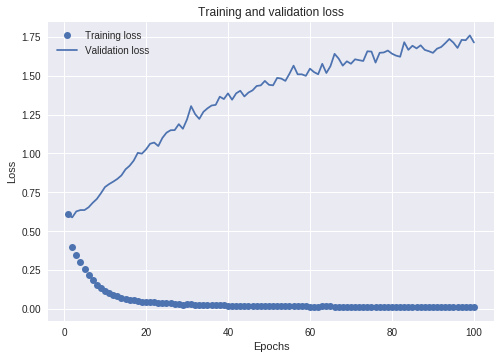

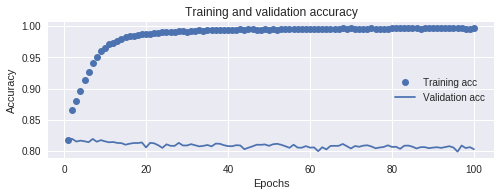

In [ ]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Tuning

In [ ]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.3)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [ ]:
batch_size = 128
epochs = 30
drop_ratio = 0.1
run_experiment(batch_size, epochs, drop_ratio)

batch size: 128, epochs: 30, drop_ratio: 0.1
	Test loss: 1.695047058367003
	Test accuracy: 0.7446214027763179


In [ ]:
#for batch_size in range(10,31,10):
#  for epochs in range(3,40,5):
#    for drop_ratio in np.linspace(0.1,0.5,3):
#      run_experiment(batch_size, epochs, drop_ratio)

#Confusion Matrix

In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)
    
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

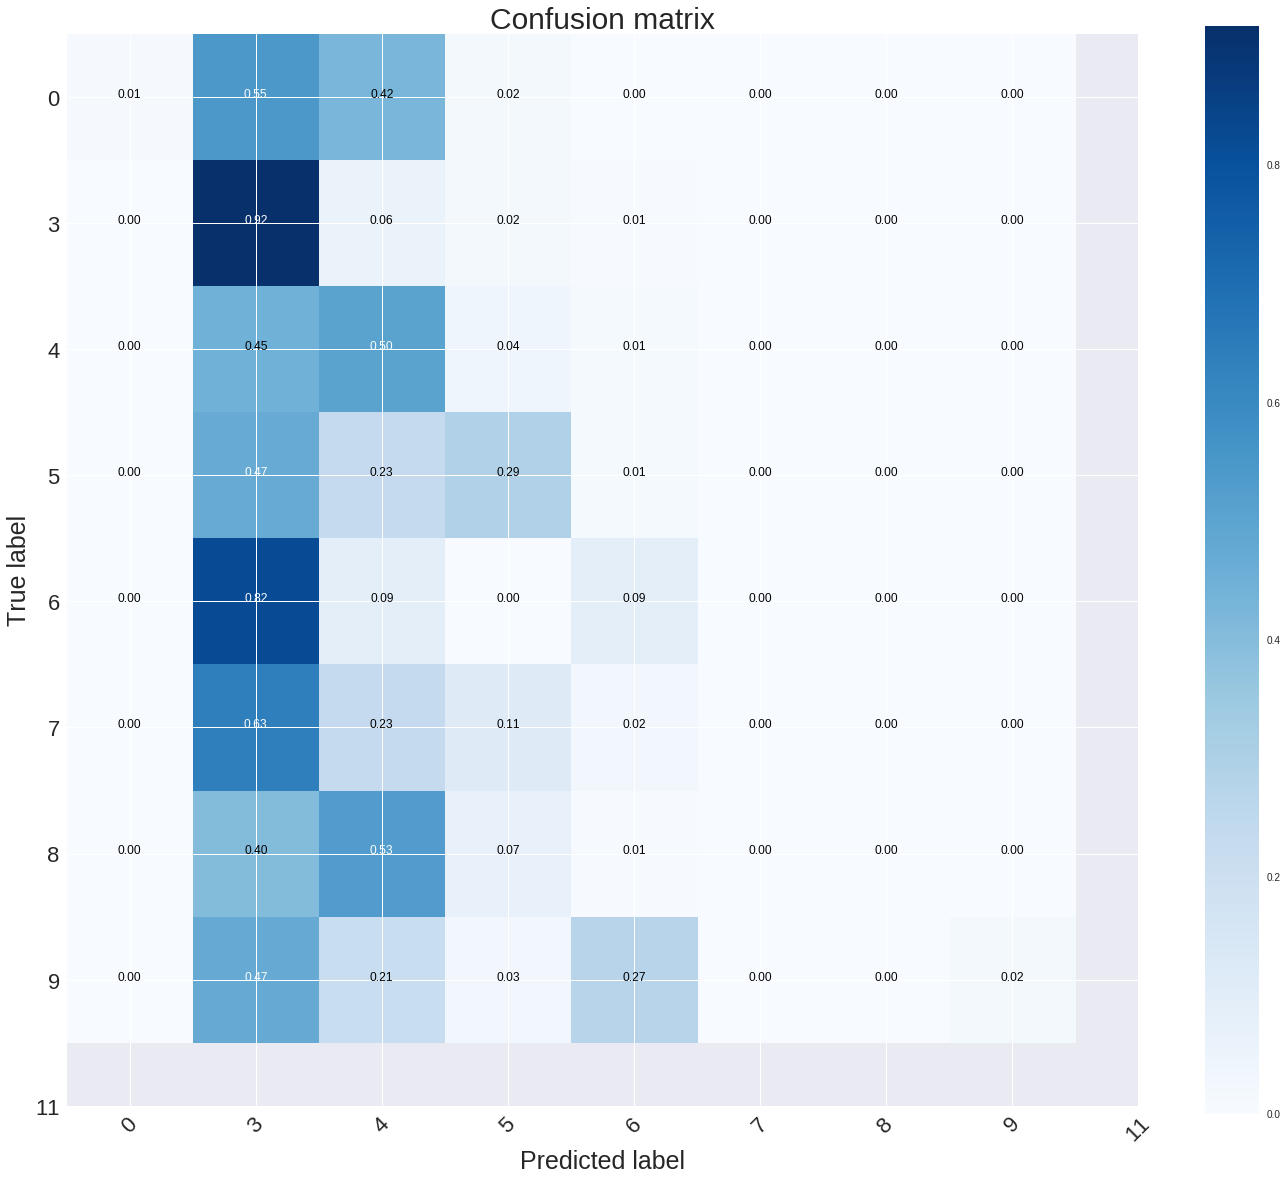

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=encoder.classes_ , title="Confusion matrix")
plt.show()

#Making Preditcions

In [ ]:
text_labels = encoder.classes_ 
print(text_labels)

[ 0  3  4  5  6  7  8  9 11]


In [ ]:
import random
rand_ = []
for x in range(10):
  rand_.append(random.randint(1,10000))
print(rand_)

[3878, 3541, 5163, 9181, 774, 3344, 1478, 5592, 4330, 5391]


In [ ]:
for i in rand_:
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + str(test_cat.iloc[i]))
    print("Predicted label: " + str(predicted_label) + "\n") 

re notification fusion post upgrade issues resolve ...
Actual label:4
Predicted label: 4

error installing tried upgrade error what next ...
Actual label:5
Predicted label: 5

cards error mode dear have card error mode for day ...
Actual label:4
Predicted label: 4

sent wednesday rejected reason cannot be seen impo ...
Actual label:4
Predicted label: 4

re we updated wireless networks colombia hi can yo ...
Actual label:5
Predicted label: 4

up message with entering password hi can you help  ...
Actual label:4
Predicted label: 4

original message sent thursday december critical a ...
Actual label:8
Predicted label: 5

sent thursday issues dear teams one our observed t ...
Actual label:11
Predicted label: 4

issues hello cannot connect via after couple secon ...
Actual label:4
Predicted label: 4

malfunction th floor hello could you please help r ...
Actual label:6
Predicted label: 5



In [ ]:
#@title Make a prediction

User_Input = "please note i would like to request my paternity leave within next week if possible" #@param 


In [ ]:
test_test = User_Input
#tokenize
tokenize.fit_on_texts(test_test)
z_test = tokenize.texts_to_matrix(test_test)

#predict
prediction = model.predict(np.array([z_test[0]]))
print(prediction)

#align to labels
print(text_labels)
predicted_label = text_labels[np.argmax(prediction)]
print("Predicted label: " + str(predicted_label) + "\n") 

[[4.7047717e-05 1.2509858e-04 5.5377114e-01 2.7448583e-01 2.2785217e-03
  1.8756217e-03 7.6518349e-02 9.0522893e-02 3.7549314e-04]]
[ 0  3  4  5  6  7  8  9 11]
Predicted label: 4

